### Notebook Information

#### In this notebook we are running the ResNet 34 model on CIFAR 10 dataset

In [1]:
# Importing the Required libraries for this Project
# Import numpy
import numpy as np
# get Pytorch
import torch
# get torch.nn for model layers
import torch.nn as nn

In [2]:
# Setting the device 
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

In [3]:
from numpy.lib.shape_base import dstack
# Getting the Dataset from the datasets library

from torchvision import datasets as ds
from torchvision import transforms as tfs
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data as tud
# Creating a function to load our data and passing all the required parameters

def load_data_project(dataAddr, bs1, vs=0.1, test=False, sf=True):  
    nrm = tfs.Normalize(mean=[0.4913, 0.4821, 0.4466],std=[0.2470, 0.2435, 0.2615],)

    tf = tfs.Compose([tfs.Resize((224,224)), tfs.ToTensor(), nrm,])

    # If we are trying to load the test dataset
    if test == True:
        dsCurr = ds.CIFAR100(root=dataAddr, download=True, train=False,transform=tf,)

        load_data_project = tud.DataLoader(dsCurr, batch_size=bs1, shuffle=sf)

        return load_data_project

    # get the dataset into train and validation variables
    dsCurrTrain = ds.CIFAR100(root=dataAddr, train=True, download=True, transform=tf,)

    dsCurrValid = ds.CIFAR100(root=dataAddr, train=True, download=True, transform=tf, )

    x = len(dsCurrTrain)
    poss = list(range(x))
    div = int(np.floor(vs * x))

    # To check and shuffle data accordingly
    if sf == True:
        np.random.shuffle(poss)

        np.random.seed(42)

    train_idx, valid_idx = poss[div:], poss[:div]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    trainLoaderCurr = tud.DataLoader(dsCurrTrain, batch_size=bs1, sampler=train_sampler)
    validLoaderCurr = tud.DataLoader(dsCurrValid, batch_size=bs1, sampler=valid_sampler)
    return (trainLoaderCurr, validLoaderCurr)
 
train_loader, valid_loader = load_data_project('./data',64)

test_loader = load_data_project('./data',64,test=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [4]:
class ResBlk(nn.Module):
    def __init__(self, inputChannels, outputChannels, sd = 1, dsample = None):
        super(ResBlk, self).__init__()
        self.convolution1 = nn.Sequential(nn.Conv2d(inputChannels, outputChannels,padding = 1, kernel_size = 3, stride = sd), nn.BatchNorm2d(outputChannels),  nn.ReLU())
        self.convolution2 = nn.Sequential( nn.Conv2d(outputChannels, outputChannels, padding = 1, kernel_size = 3, stride = 1), nn.BatchNorm2d(outputChannels))
        self.ds = dsample
        self.relu = nn.ReLU()
        self.out_channels = outputChannels
        
    def forward(self, x):
        res = x
        output1 = self.convolution1(x)
        output1 = self.convolution2(output1)
        if self.ds:
            res = self.ds(x)
        output1 += res
        output1 = self.relu(output1)
        return output1

In [5]:
class ResNet34(nn.Module):
    def __init__(self, block, layers, classes_cifar = 100):
        super(ResNet34, self).__init__()
        self.inplanes = 64
        self.convolution1 = nn.Sequential( nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3), nn.BatchNorm2d(64), nn.ReLU())
        self.maxpoolingLayer = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.l0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.l1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.l2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.l3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.Averagepool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, classes_cifar)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        Model_layers = []
        Model_layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            Model_layers.append(block(self.inplanes, planes))

        return nn.Sequential(*Model_layers)
    
    
    def forward(self, x1):
        x1 = self.convolution1(x1)
        x1 = self.maxpoolingLayer(x1)
        x1 = self.l0(x1)
        x1 = self.l1(x1)
        x1 = self.l2(x1)
        x1 = self.l3(x1)

        x1 = self.Averagepool(x1)
        x1 = x1.view(x1.size(0), -1)
        x1 = self.fc(x1)

        return x1


In [8]:
classes_cifar = 100
epochs = 60
batch_size = 16
lr_eta = 0.1

model = ResNet34(ResBlk, [3, 4, 6, 3]).to(device)

# Loss and optimizer
loss_func = nn.CrossEntropyLoss()
optim_func = torch.optim.SGD(model.parameters(), lr=lr_eta, weight_decay = 0.001, momentum = 0.9)  

# Train the model
steps = len(train_loader)

In [9]:
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,928
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           ResBlk-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,928
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
import gc
steps = len(train_loader)

intermidiate_cost_history = []
inter_rights_history = []
val_intermidiate_cost_history = []
val_intermidiate_correct_cost_history = []

for temp in range(epochs):

    inter_cost = 0.0
    inter_rights = 0.0
    val_inter_cost = 0.0
    val_inter_rights = 0.0 

    for i, (imgs, lbls) in enumerate(train_loader):
        # Move tensors to the configured device
        imgs = imgs.to(device)
        lbls = lbls.to(device)
        
        # Forward pass
        model_output = model(imgs)
        loss = loss_func(model_output, lbls)
        # print("Loss -")
        # print(loss)
        # print("Labels -")
        # print(labels)

        optim_func.zero_grad()
        loss.backward()
        optim_func.step()
        _, preds = torch.max(model_output, 1) # taking the highest value of prediction.
        inter_cost += loss.item()
        inter_rights += torch.sum(preds == lbls.data)

        del imgs, lbls, model_output
        torch.cuda.empty_cache()
        gc.collect()

    print ('Epoch number ['+ temp+1 +'], the loss is: {:.4f}'.format(loss.item()))
            
    # Validation
    with torch.no_grad():
        rights = 0
        all = 0
        for imgs, lbls in valid_loader:
            imgs = imgs.to(device)
            lbls = lbls.to(device)
            model_output = model(imgs)
            _, predicted = torch.max(model_output.data, 1)
            all += lbls.size(0)
            rights += (predicted == lbls).sum().item()
            val_cost = loss_func(model_output, lbls)
            _, val_predictions = torch.max(model_output, 1)
            val_inter_cost += val_cost.item()
            val_inter_rights += torch.sum(val_predictions == lbls.data)
            del imgs, lbls, model_output
    
        print('Accuracy on {} Validation images is: {} %'.format(5000, 100 * rights / all)) 

    epoch_cost = inter_cost/len(train_loader) # loss per epoch
    epoch_acc = inter_rights.float()/ len(train_loader) # accuracy per epoch
    epoch_acc.to(device)
    intermidiate_cost_history.append(epoch_cost) # appending for displaying 
    inter_rights_history.append(epoch_acc)
    
    val_epoch_cost = val_inter_cost/len(valid_loader)
    val_epoch_acc = val_inter_rights.float()/ len(valid_loader)
    val_intermidiate_cost_history.append(val_epoch_cost)
    val_intermidiate_correct_cost_history.append(val_epoch_acc)

Epoch number [1], the loss is: 4.6030
Accuracy on 5000 Validation images is: 9.76 %
Epoch number [2], the loss is: 4.4618
Accuracy on 5000 Validation images is: 16.98 %
Epoch number [3], the loss is: 3.7961
Accuracy on 5000 Validation images is: 25.02 %
Epoch number [4], the loss is: 2.6173
Accuracy on 5000 Validation images is: 30.44 %
Epoch number [5], the loss is: 2.5133
Accuracy on 5000 Validation images is: 31.78 %
Epoch number [6], the loss is: 2.4750
Accuracy on 5000 Validation images is: 35.46 %
Epoch number [7], the loss is: 2.9749
Accuracy on 5000 Validation images is: 37.58 %
Epoch number [8], the loss is: 2.0085
Accuracy on 5000 Validation images is: 37.08 %
Epoch number [9], the loss is: 1.8882
Accuracy on 5000 Validation images is: 40.58 %
Epoch number [10], the loss is: 2.1757
Accuracy on 5000 Validation images is: 42.94 %
Epoch number [11], the loss is: 1.8535
Accuracy on 5000 Validation images is: 42.88 %
Epoch number [12], the loss is: 2.0987
Accuracy on 5000 Validati

In [ ]:
acc_history = []
type(inter_rights_history)
for i in inter_rights_history:
  acc_history.append(i.item())
val_history = []
for i in val_intermidiate_correct_cost_history:
  val_history.append(i.item())

In [ ]:
intermidiate_cost_history

[4.1741146871989425,
 3.5206179950724947,
 3.0879088345576418,
 2.7669655843214556,
 2.5627796170725063,
 2.4539632221514527,
 2.3432543480938133,
 2.2573068370534615,
 2.1909240277653392,
 2.1332861693067984,
 2.07982148619538,
 2.0325289270417257,
 1.9911714939569884,
 1.963466905396093,
 1.9326947820796208,
 1.9140549601817674,
 1.9015554912726989,
 1.8878056112338195,
 1.8862276967953553,
 1.8592631493441083,
 1.8547266904603352,
 1.8495892631736668,
 1.8354031015187502,
 1.839565164663575,
 1.8340040237050166,
 1.8273367236622355,
 1.8294202744622121,
 1.8217448074031959,
 1.8235302885824984,
 1.8099644595587796]

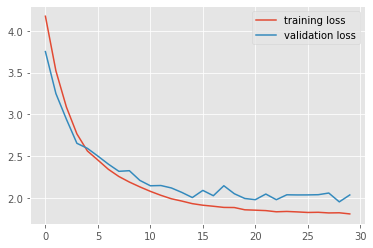

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.plot(intermidiate_cost_history, label='training loss')
plt.plot(val_intermidiate_cost_history, label='validation loss')
plt.legend()

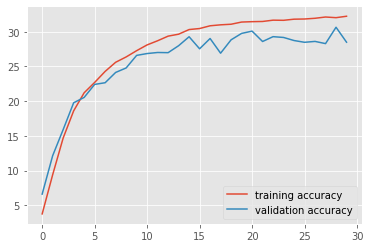

In [ ]:
plt.style.use('ggplot')
plt.plot(acc_history, label='training accuracy')
plt.plot(val_history, label='validation accuracy')
plt.legend()

In [ ]:
torch.save(model.state_dict(), 'model_cifar100_resnet34.pt')

In [1]:
with torch.no_grad():
    rights = 0
    all = 0
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        lbls = lbls.to(device)
        model_output = model(imgs)
        _, predicted = torch.max(model_output.data, 1)
        all += lbls.size(0)
        rights += (predicted == lbls).sum().item()
        del imgs, lbls, model_output

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * rights / all))


Accuracy of the network on the 10000 test images: 47.5 %
